## Analyzing AWS Palace results (flux through a qubit SQUID loop) with [scQubits](https://scqubits.readthedocs.io/en/latest/)

In [1]:
import scqubits as scq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h
phi0 = 2.0678338484619295e-15 # flux qu santum

In [2]:
## read in the flux data ##
phi_df = pd.read_csv("magneto_output/surface-F.csv",usecols = [1])
phi_df.columns = ["flux"]

## read in the current data ##
current_df = pd.read_csv("magneto_output/terminal-I.csv",usecols = [1])
current_df.columns = ["current"]

## Calculate $\frac{d\Phi}{dI}$ in units of flux quantum $\Phi_0$

In [3]:
# divide the flux through our SQUID loop by the terminal current to get flux per unit current [weber / ampere]
dphi_dI = phi_df.flux.to_numpy() / current_df.current.to_numpy() 

## convert to units of flux quantum ## 
norm_dphi_dI = abs(dphi_dI/phi0) # normalize

## SQUID loop parameters for scqubits 

In [4]:
# assume both junctions have LJ ≈ 10 nH
LJ = 10e-9 # 10 nH 
EJ = phi0**2/((2*np.pi)**2*LJ)
EJ_MHz = EJ / h * 1e-6 # convert to MHz

# EJ and EC in MHz 
EJmax = 2*EJ_MHz # EJMax = EJ1 + EJ2 ≈ 2*EJ1 = 2*EJ_MHz
EC= 177.33 # see Qubit Hamiltonian from Capacitance Matrix (Electrostatics) xmon example in pyPalace
junction_asymmetry = .01 # give the SQUID loop some asymmetry 

## Analyzing the flux tunability of our qubit

In [5]:
## current through flux line ###
current = np.linspace(0,10*10**(-3),25)

frequencies = []
for I in current:
    flux = I * norm_dphi_dI
    qubit = scq.TunableTransmon(EJmax=EJmax,
                                         EC=EC,
                                         d=junction_asymmetry,
                                         flux=flux,
                                         ng=0.0,
                                         ncut=30
                                        )
    frequencies.append(qubit.E01())
    
frequencies = np.array(frequencies)

### Qubit Frequency vs Flux Bias Line Current

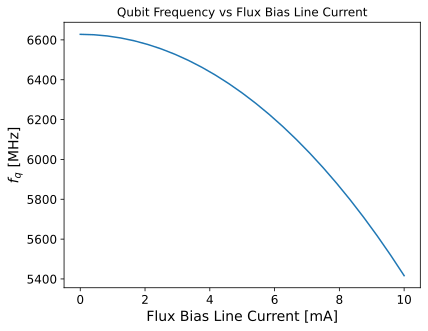

In [6]:
fig,ax = plt.subplots()
plt.plot(current*1000,frequencies)

plt.xlabel("Flux Bias Line Current [mA]",fontsize = 14)
plt.ylabel(r"$f_q$ [MHz]",fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.title("Qubit Frequency vs Flux Bias Line Current")
plt.savefig("Figures/f_vs_current.png",bbox_inches='tight')

### Qubit Frequency vs $\frac{\Phi}{\Phi_0}$

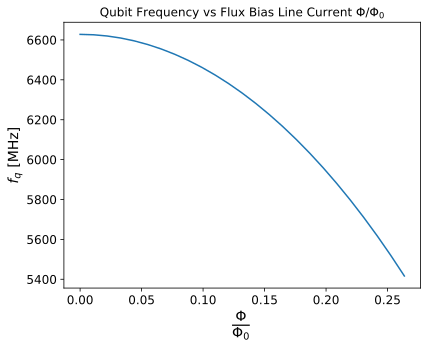

In [7]:
phi_over_phi0 = current * norm_dphi_dI
plt.plot(phi_over_phi0,frequencies)

plt.xlabel(r"$\frac{\Phi}{\Phi_0}$",fontsize = 20)
plt.ylabel(r"$f_q$ [MHz]",fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.title(r"Qubit Frequency vs Flux Bias Line Current $\Phi/\Phi_0$")
plt.savefig("Figures/f_vs_phi.png",bbox_inches='tight')